### Pilot Run with 4 subfolders: intraparenchymal, epidural, subdural, intraventricular

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


#### Load data

In [3]:
parent_folder = "/Users/peng.hsiaoyu/Downloads/BrainCTScan/"
img_subfolders = ["epidural_merged", "intraparenchymal_merged",  "subdural_merged", "intraventricular_merged"]
mask_subfolders = ["epidural_mask", "intraparenchymal_mask", "subdural_mask", "intraventricular_mask"]

def load_data(parent_folder, img_subfolders, mask_subfolders):
    images = []
    masks = []

    for img_subfolder, mask_subfolder in zip(img_subfolders, mask_subfolders):
        img_folder_path = os.path.join(parent_folder, img_subfolder)
        mask_folder_path = os.path.join(parent_folder, mask_subfolder)

        for filename in os.listdir(img_folder_path):
            if filename.endswith(".jpg"):
                img_path = os.path.join(img_folder_path, filename)
                mask_filename = filename.replace("merged", "mask").replace(".jpg", "_mask.jpg")
                mask_path = os.path.join(mask_folder_path, mask_filename)

                img = img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0
                mask = img_to_array(load_img(mask_path, target_size=(256, 256), color_mode="grayscale")) / 255.0

                images.append(img)
                masks.append(mask)

    return np.array(images), np.array(masks)


images, masks = load_data(parent_folder, img_subfolders, mask_subfolders)


In [4]:
 images.shape, masks.shape

((2448, 256, 256, 3), (2448, 256, 256, 1))

#### Data analysis

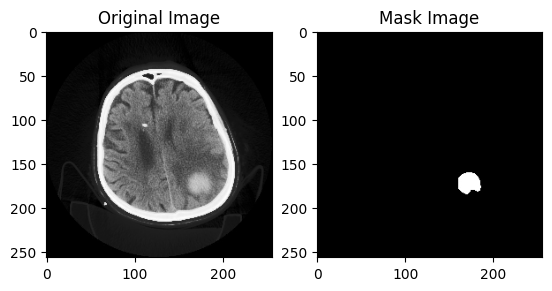

In [22]:
import random
import matplotlib.pyplot as plt

# Randomly choose one index
random_index = random.randint(0, len(images) - 1)

# Choose images and corresponding mask
random_image = images[random_index]
random_mask = masks[random_index]

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.title('Original Image')

# Show mask image
plt.subplot(1, 2, 2)
plt.imshow(random_mask[:, :, 0], cmap='gray')  
plt.title('Mask Image')

plt.show()


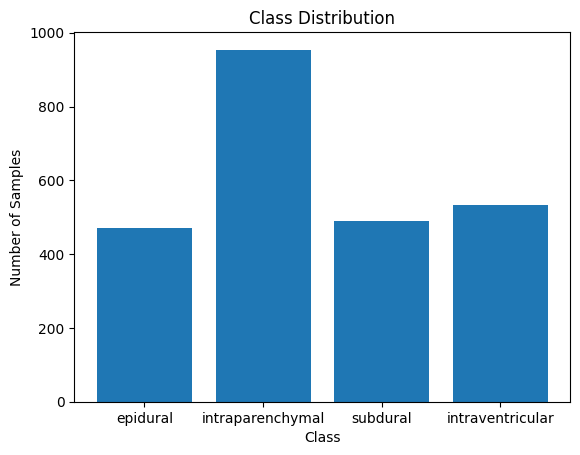

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check class distribution
def check_data_distribution(parent_folder, subfolders):
    class_counts = {}

    for subfolder in subfolders:
        folder_path = os.path.join(parent_folder, subfolder)
        class_name = subfolder.split("_")[0]  # Extract class name，e.g., "normal"、"epidural" etc.

        # Calculate counts in each class
        class_counts[class_name] = len(os.listdir(folder_path))



    # Visualize class distribution
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Check class distribution
check_data_distribution(parent_folder, img_subfolders)

#### Data processing


In [9]:
from sklearn.model_selection import train_test_split

# Split training/validation/test data set
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Check the training/validation/test sizse
print(f"訓練集大小：{len(train_images)}")
print(f"驗證集大小：{len(val_images)}")
print(f"測試集大小：{len(test_images)}")


訓練集大小：1566
驗證集大小：392
測試集大小：490


#### Build model Unet

In [10]:
IMG_SIZE = 256

# Method 1: Enlarge feature maps by UpSampling2D
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
c1 = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = layers.MaxPool2D()(c1)
c2 = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c2)
c3 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = layers.MaxPool2D()(c3)
c4 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

# Decoder
l = layers.concatenate([layers.UpSampling2D()(c4),
                        c3], axis=-1)
l = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D()(l),
                        c2], axis=-1)
l = layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = layers.concatenate([layers.UpSampling2D()(l),
                        c1], axis=-1)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(l)

# Output
output_layer = layers.Conv2D(filters=1,
                             kernel_size=1,
                             activation='sigmoid')(l)

model = models.Model(input_layer, output_layer)

In [11]:
# utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Training

In [12]:
# Customize Metrics: Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Customize Dice Loss
def dice_loss(y_true, y_pred):
    dice = dice_coef(y_true, y_pred)
    return 1 - dice

In [14]:
model.compile(optimizer=optimizers.legacy.Adam(),
              loss='binary_crossentropy', # keras.losses.BinaryCrossentropy()
            #   loss=dice_loss,
              metrics=[dice_coef])

In [15]:
weight_saver = callbacks.ModelCheckpoint('/Users/peng.hsiaoyu/Downloads/BrainCTScan/3unet_seg.h5',
                                         save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    patience=5)

In [16]:
logs = model.fit(train_images, train_masks,
                 validation_data=(val_images, val_masks),
                 epochs=100,
                 callbacks = [weight_saver, earlystop])



Epoch 1/100
49/49 [==============================] - 371s 8s/step - loss: 0.1308 - dice_coef: 0.0123 - val_loss: 0.0354 - val_dice_coef: 0.0336
Epoch 2/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 401s 8s/step - loss: 0.0354 - dice_coef: 0.0337 - val_loss: 0.0333 - val_dice_coef: 0.0385
Epoch 3/100
49/49 [==============================] - 348s 7s/step - loss: 0.0348 - dice_coef: 0.0400 - val_loss: 0.0334 - val_dice_coef: 0.0359
Epoch 4/100
49/49 [==============================] - 265s 5s/step - loss: 0.0355 - dice_coef: 0.0339 - val_loss: 0.0336 - val_dice_coef: 0.0371
Epoch 5/100
49/49 [==============================] - 275s 6s/step - loss: 0.0349 - dice_coef: 0.0370 - val_loss: 0.0323 - val_dice_coef: 0.0443
Epoch 6/100
49/49 [==============================] - 265s 5s/step - loss: 0.0333 - dice_coef: 0.0453 - val_loss: 0.0307 - val_dice_coef: 0.0622
Epoch 7/100
49/49 [==============================] - 272s 6s/step - loss: 0.0332 - dice_coef: 0.0510 - val_loss: 0.0302 - val_dice_coef: 0.0675
Epoch 8/100
49/49 [==============================] - 276s 6s/step - loss: 0.0327 - dice_coef: 0.0617 - val_loss: 0.0355 - val_dice_coef: 0.0699
Epoc

#### Evaluate

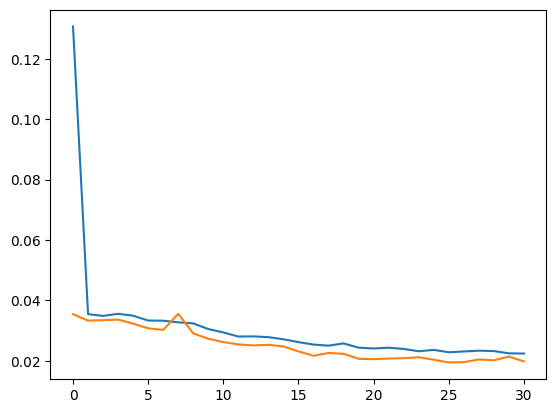

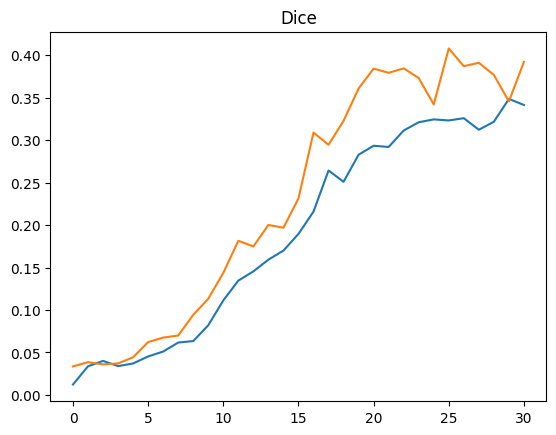

In [26]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.savefig('/Users/peng.hsiaoyu/Downloads/BrainCTScan/loss_plot_20231204.png') # Adjust the filename and format as needed
plt.show()

plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.savefig('/Users/peng.hsiaoyu/Downloads/BrainCTScan/dice_plot_20231204.png') 
plt.show()

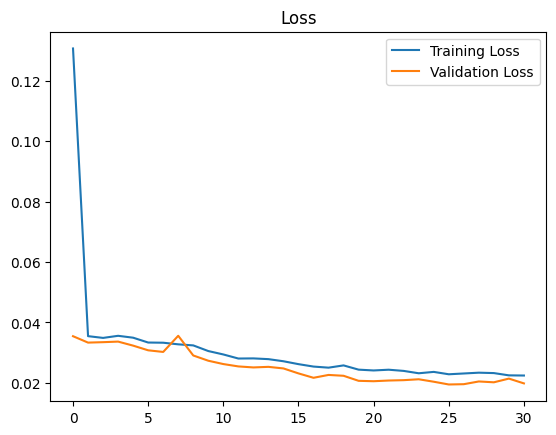

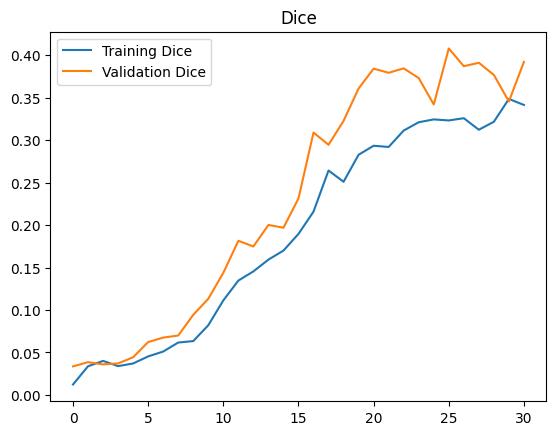

In [27]:
# Assuming history is a dictionary with keys 'loss', 'val_loss', 'dice_coef', 'val_dice_coef'
history = logs.history

# Plot the loss curve
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()  # Add legend to the plot
plt.show()

# Plot the Dice curve
plt.plot(history['dice_coef'], label='Training Dice')
plt.plot(history['val_dice_coef'], label='Validation Dice')
plt.title('Dice')
plt.legend()  # Add legend to the plot
plt.show()

In [ ]:
model_final = models.load_model('unet_seg.h5', compile=False)

In [18]:
# Predict on test images
predictions = model.predict(test_images)

# Calculate IoU
intersection = np.logical_and(test_masks, predictions)
union = np.logical_or(test_masks, predictions)
iou = np.sum(intersection) / np.sum(union)

print(f"IoU: {iou}")


16/16 [==============================] - 24s 1s/step
IoU: 0.009062630789620536


In [19]:
print(dice_coef(test_masks, predictions))

print(dice_loss(test_masks, predictions))

tf.Tensor(0.35648638, shape=(), dtype=float32)
tf.Tensor(0.6435136, shape=(), dtype=float32)


In [28]:
# Assuming you have functions dice_coef and dice_loss defined

# Calculate Dice coefficient and Dice loss
dice_coefficient = dice_coef(test_masks, predictions)
dice_loss_value = dice_loss(test_masks, predictions)

# Print the results
print(f'Dice Coefficient on Test Set: {dice_coefficient:.4f}')
print(f'Dice Loss on Test Set: {dice_loss_value:.4f}')


Dice Coefficient on Test Set: 0.3565
Dice Loss on Test Set: 0.6435


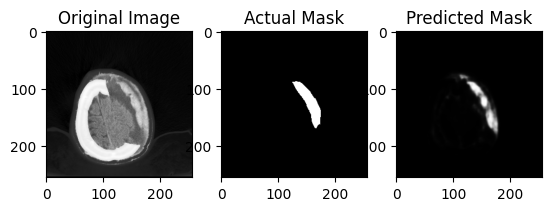

In [20]:
# Visualize original image, actual mask, and predicted mask
index = random.randint(0, len(test_images) - 1)

plt.subplot(1, 3, 1)
plt.imshow(test_images[index])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(test_masks[index][:, :, 0], cmap='gray')
plt.title('Actual Mask')

plt.subplot(1, 3, 3)
plt.imshow(predictions[index][:, :, ], cmap='gray')
plt.title('Predicted Mask')

plt.show()

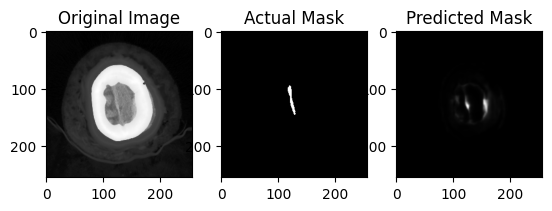

In [45]:
# Visualize original image, actual mask, and predicted mask
index = random.randint(0, len(test_images) - 1)

plt.subplot(1, 3, 1)
plt.imshow(test_images[index])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(test_masks[index][:, :, 0], cmap='gray')
plt.title('Actual Mask')

plt.subplot(1, 3, 3)
plt.imshow(predictions[index][:, :, ], cmap='gray')
plt.title('Predicted Mask')

output_file_path = '/Users/peng.hsiaoyu/Downloads/BrainCTScan/output_prediction_image.jpg'
plt.savefig(output_file_path, format='jpeg', dpi=300)  # You can adjust the DPI as needed

plt.show()